In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'random'
data_setting = 'rawflt'
model_setting = 'conv1d'

d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

# X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 0.63 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.38 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 1.37 seconds.
Species: An. arabiensis.
Read 19297 filenames in 1.37 seconds.
Species: An. gambiae.
Read 49471 filenames in 1.37 seconds.
Species: C. pipiens.
Read 30415 filenames in 1.46 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 1.47 seconds.


{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

## Choosing model (6 classes or 3-merged)

In [2]:
merged = False

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(nb_classes=3, model_setting=model_setting, data_setting=data_setting).config
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(nb_classes=6, model_setting=model_setting, data_setting=data_setting).config

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

############ INPUT SHAPE:(5000, 1)


In [3]:
d.target_classes

['Ae. aegypti',
 'Ae. albopictus',
 'An. arabiensis',
 'An. gambiae',
 'C. pipiens',
 'C. quinquefasciatus']

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization (BatchNo (None, 4996, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4992, 32)          128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2496, 32)          0

In [5]:
# sig = next(valid_generator(X_val, y_val,
#                 batch_size=traincf.batch_size,
#                 target_names=traincf.target_names,
#                 setting=traincf.setting,
#                 preprocessing_train_stats='',
#                 using_conv2d=using_conv2d))[0][0,:,:]
# plt.plot(sig)

In [6]:
pd.Series(y_val).value_counts()

0    14798
5    12904
3     8557
4     5261
1     3499
2     3338
dtype: int64

### Model training

In [7]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
6045/6045 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7768
Epoch 00001: val_loss improved from inf to 5.48953, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_random_rawflt_conv1d_weights.h5
6045/6045 [==============================] - 3339s 552ms/step - loss: 0.6138 - accuracy: 0.7768 - val_loss: 5.4895 - val_accuracy: 0.0776 - lr: 0.0010
Epoch 2/100
6044/6045 [============================>.] - ETA: 0s - loss: 0.4243 - accuracy: 0.8471
Epoch 00002: val_loss did not improve from 5.48953
6045/6045 [==============================] - 386s 64ms/step - loss: 0.4243 - accuracy: 0.8471 - val_loss: 9.0918 - val_accuracy: 0.5143 - lr: 0.0010
Epoch 3/100
6045/6045 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8701
Epoch 00003: val_loss did not improve from 5.48953
6045/6045 [==============================] - 250s 41ms/step - loss

In [8]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [10]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=np.unique(y_test).tolist(),
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [11]:
features.shape

(37781, 6)

### Confusion matrix (test set)

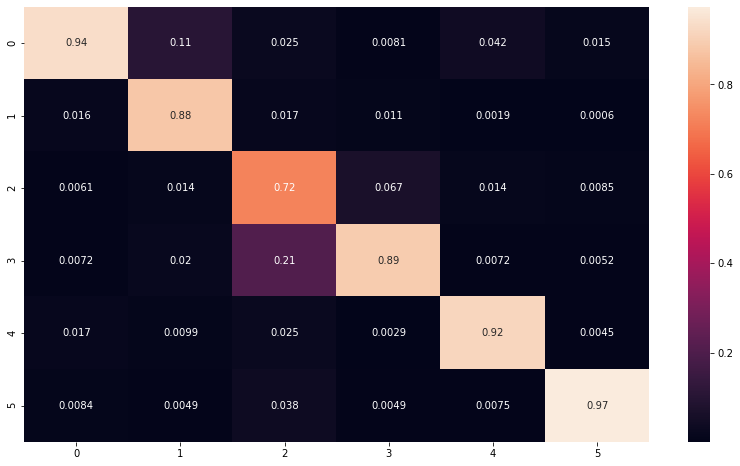

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(14,8))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)#, fmt='g')

In [13]:
pd.Series(y_test).value_counts()

0    11562
5    10081
3     6686
4     4110
1     2734
2     2608
dtype: int64

In [14]:
pd.Series(np.argmax(features, axis=1)).value_counts()

0    11652
5    10016
3     6794
4     4158
1     2637
2     2524
dtype: int64

In [15]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'rawflt'
model_setting = 'conv1d'

d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 0.66 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.45 seconds.
['20170212', '20170211', '20170209', '20170208', '20170210', '20170207', '20170213', '20161213', '20170206', '20161212']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 1.45 seconds.
['20170301', '20170228', '20170227', '20170103', '20170102']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 1.45 seconds.
['20170131', '20170317', '20170318', '20170320', '20170205', '20170203', '20170204', '20170202', '20170319', '20170313', '20170201', '20170314', '20170316', '20170130', '20170206', '20170315']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 1.44 seconds.
['20170121', '20170120', '20170123', '20170118', '20170117', '20170119', '20170116', '20170122', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Rea

{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

## Choosing model (6 classes or 3-merged)

In [16]:
merged = False

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    traincf = TrainConfiguration(nb_classes=3, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(nb_classes=3, model_setting=model_setting, data_setting=data_setting).config
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
    traincf = TrainConfiguration(nb_classes=6, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(nb_classes=6, model_setting=model_setting, data_setting=data_setting).config

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

############ INPUT SHAPE:(5000, 1)


In [17]:
d.target_classes

['Ae. aegypti',
 'Ae. albopictus',
 'An. arabiensis',
 'An. gambiae',
 'C. pipiens',
 'C. quinquefasciatus']

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 4998, 16)          64        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization_5 (Batch (None, 4996, 16)          64        
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_6 (Batch (None, 4992, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2496, 32)         

In [19]:
# sig = next(valid_generator(X_val, y_val,
#                 batch_size=traincf.batch_size,
#                 target_names=traincf.target_names,
#                 setting=traincf.setting,
#                 preprocessing_train_stats='',
#                 using_conv2d=using_conv2d))[0][0,:,:]
# plt.plot(sig)

In [20]:
pd.Series(y_val).value_counts()

0    16597
3     9094
5     8310
4     5670
1     3488
2     2579
dtype: int64

### Model training

In [21]:
h = model.fit(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Epoch 1/100
5718/5718 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7894
Epoch 00001: val_loss improved from inf to 5.69266, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_custom_rawflt_conv1d_weights.h5
5718/5718 [==============================] - 264s 46ms/step - loss: 0.5837 - accuracy: 0.7894 - val_loss: 5.6927 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 2/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.3868 - accuracy: 0.8627
Epoch 00002: val_loss did not improve from 5.69266
5718/5718 [==============================] - 233s 41ms/step - loss: 0.3868 - accuracy: 0.8627 - val_loss: 5.9591 - val_accuracy: 0.3920 - lr: 0.0010
Epoch 3/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy: 0.8862
Epoch 00003: val_loss did not improve from 5.69266
5718/5718 [==============================] - 233s 41ms/step - loss: 0.3213 - accuracy: 0.8862 - val_loss: 119.8134 - val_accuracy: 0.0563 - lr: 

In [22]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [24]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=np.unique(y_test).tolist(),
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

In [25]:
features.shape

(47295, 6)

### Confusion matrix (test set)

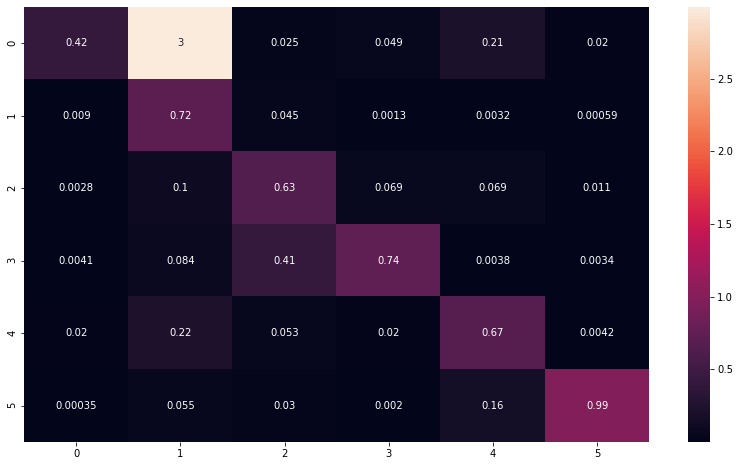

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(14,8))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)#, fmt='g')

In [27]:
pd.Series(y_test).value_counts()

5    33047
3     4000
2     2831
1     2791
0     2564
4     2062
dtype: int64

In [28]:
pd.Series(np.argmax(features, axis=1)).value_counts()

5    32212
0     5679
3     4528
2     2360
4     1847
1      669
dtype: int64